# Домашнее задание к занятию 2.1: Деревья решений. Классификация

**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

**Результат:** скрины нового сабмита на Kaggle и построенного дерева

### Реализация lvl 1

In [17]:
import numpy as np
import pandas as pd
import re

In [18]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = (7, 4)

In [19]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#sample_submission = pd.read_csv('gender_submission.csv')

In [20]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [21]:
 train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### Заполним пустые значения
занолним все пропушенные данные, прям сразу на входе

In [23]:
data = [train, test]

In [24]:
#заполним пропущенные значения признака Age
for dataset in data:
    mean = train["Age"].mean()
    std = test["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # сгенерируем случайный возраст
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # заполним пропуски
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train["Age"].astype(int)

In [25]:
#заполним пропущенные значения признака Cabin (честно я подсмотрел идею делить кабину на палубы и тд)
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train, test]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

In [26]:
#заполним пропущенные значения признака Embarked
common_value = 'S'
data = [train, test]
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')


In [27]:
#заполним пропущенные значения признака Embarked
common_value = train['Fare'].mean()
data = [train, test]
for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(common_value)



In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null int64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
Deck           891 non-null int64
dtypes: float64(1), int64(7), object(4)
memory usage: 83.6+ KB


### Посмотрим данные и подготовим фичи

In [29]:
#сохраним признак Survived в y_train
y_train = train.Survived
y_train1 = train.Survived

train.drop('Survived', axis=1, inplace=True)

In [30]:
#посмотрим на соответствие признаков в test и train
train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [31]:
#сольем train и test для удобства обработки и для последующего разделения добавим разметку
train['is_test'] = 0
test['is_test'] = 1
df = pd.concat([train, test])

In [32]:
#бинаризируем признак Sex
df['isMale'] = df.Sex.replace({"male": 1, "female":0})

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null int64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Embarked       1309 non-null object
Deck           1309 non-null int64
is_test        1309 non-null int64
isMale         1309 non-null int64
dtypes: float64(1), int64(8), object(4)
memory usage: 143.2+ KB


#### Заварим немного фичей  (я очень чай люблю, так что буду вместо сварим использовать заварим)

- выдилим новый признак `FamilySize` он будет отражать кол-во совместно путешествующих человек

In [34]:
#Кол-во членов семьи
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

- выдилим новый признак `Title` мы ведь уже знаем что мужчины чаще тонут чем женьщины

In [35]:
#определим какой тайтл (не знаю как это на русский переводится)
df['Title'] = 0

for i in df:
    df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=False)

In [36]:
df.groupby('Title')['Age'].count()

Title
Capt          1
Col           4
Countess      1
Don           1
Dona          1
Dr            8
Jonkheer      1
Lady          1
Major         2
Master       61
Miss        260
Mlle          2
Mme           1
Mr          757
Mrs         197
Ms            2
Rev           8
Sir           1
Name: Age, dtype: int64

Из распределения видно что есть несколько основных категорий а остальные очень редкие, тогда выдилим основные и сделаем категорию other

In [37]:
titles_dict = {'Capt': 'Other',
               'Major': 'Other',
               'Jonkheer': 'Other',
               'Don': 'Other',
               'Sir': 'Other',
               'Dr': 'Other',
               'Rev': 'Other',
               'Countess': 'Other',
               'Dona': 'Other',
               'Mme': 'Mrs',
               'Mlle': 'Miss',
               'Ms': 'Miss',
               'Mr': 'Mr',
               'Mrs': 'Mrs',
               'Miss': 'Miss',
               'Master': 'Master',
               'Lady': 'Other'}

In [38]:
df['Title'] = df['Title'].map(titles_dict)
df['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 15 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null int64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Embarked       1309 non-null object
Deck           1309 non-null int64
is_test        1309 non-null int64
isMale         1309 non-null int64
FamilySize     1309 non-null int64
Title          1305 non-null object
dtypes: float64(1), int64(9), object(5)
memory usage: 163.6+ KB


In [40]:
df['Title'] = pd.Categorical(df['Title'])
df.dtypes

PassengerId       int64
Pclass            int64
Name             object
Sex              object
Age               int64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Embarked         object
Deck              int64
is_test           int64
isMale            int64
FamilySize        int64
Title          category
dtype: object

In [41]:
df['Title'].unique()

[Mr, Mrs, Miss, Master, Other, NaN]
Categories (5, object): [Mr, Mrs, Miss, Master, Other]

In [42]:
df.loc[df.Title == 'NaN', 'Title'] = 'Mr'
df['Title'].unique()

[Mr, Mrs, Miss, Master, Other, NaN]
Categories (5, object): [Mr, Mrs, Miss, Master, Other]

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 15 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null int64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Embarked       1309 non-null object
Deck           1309 non-null int64
is_test        1309 non-null int64
isMale         1309 non-null int64
FamilySize     1309 non-null int64
Title          1305 non-null category
dtypes: category(1), float64(1), int64(9), object(4)
memory usage: 154.9+ KB


- напишем функцию `age_cat` она будет присваивать категорию возрастной группе сгенерируем фичу age_cat_clf

In [44]:
def age_cat(age):
    """
    
    """
    if 11 >= age:
        return 0
    elif 11 < age <= 18:
        return 1
    elif 18 < age <= 22:
        return 2
    elif 22 < age <= 27:
        return 3
    elif 27 < age <= 33:
        return 4
    elif 33 < age <= 40:
        return 5
    elif 40 < age <= 66:
        return 6
    else:
        return 7

In [45]:
df['age_cat_clf'] = df\
                .apply(lambda row: age_cat(row.Age), axis=1)

- выдилим новый признак `Age_discr` это будет маркер группы по возрасту

In [46]:
#категоризируем признак age
df['Age_discr'] = pd.cut(df['Age'], bins=[0, 12, 50, 200], labels=['Child','Adult','Elder'])
df['Age_discr'].head()

0    Adult
1    Adult
2    Adult
3    Adult
4    Adult
Name: Age_discr, dtype: category
Categories (3, object): [Child < Adult < Elder]

- напишем функцию `fare_cat` она будет присваивать категорию Fare признаку сгенерируем фичу fare_cat_cl

In [47]:
def fare_cat(fare):
    """
    
    """
    if 7.91 >= fare:
        return 0
    elif 7.91 < fare <= 14.454:
        return 1
    elif 14.454 < fare <= 31:
        return 2
    elif 31 < fare <= 99:
        return 3
    elif 99 < fare <= 250:
        return 4
    else:
        return 5

In [48]:
df['fare_cat_clf'] = df\
                .apply(lambda row: fare_cat(row.Fare), axis=1)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 18 columns):
PassengerId     1309 non-null int64
Pclass          1309 non-null int64
Name            1309 non-null object
Sex             1309 non-null object
Age             1309 non-null int64
SibSp           1309 non-null int64
Parch           1309 non-null int64
Ticket          1309 non-null object
Fare            1309 non-null float64
Embarked        1309 non-null object
Deck            1309 non-null int64
is_test         1309 non-null int64
isMale          1309 non-null int64
FamilySize      1309 non-null int64
Title           1305 non-null category
age_cat_clf     1309 non-null int64
Age_discr       1300 non-null category
fare_cat_clf    1309 non-null int64
dtypes: category(2), float64(1), int64(11), object(4)
memory usage: 176.7+ KB


In [50]:
df_dummies = pd.get_dummies(df, columns=['Title', 'Embarked', 'Age_discr'])

In [51]:
df.shape

(1309, 18)

In [52]:
#дропним лишнее
df_dummies.drop(["Sex", "Ticket", "Name", "PassengerId", "SibSp", "Parch", "Age"], axis=1, inplace=True)

In [53]:
#разделем наш набор данных обратно на test и train
X_train = df_dummies[df_dummies.is_test==0].drop('is_test', axis=1)
X_test = df_dummies[df_dummies.is_test==1].drop('is_test', axis=1)

In [54]:
columns = X_train.columns
columns1 = X_test.columns

### Заполним пустые значения

In [55]:
from sklearn.preprocessing import Imputer

In [56]:
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)

In [57]:
imputer.fit(X_train)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [58]:
X_train_imputed = imputer.transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=columns)

In [59]:
imputer.fit(X_test)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [60]:
X_test_imputed = imputer.transform(X_test)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=columns1)

### Выполним нормализацию наших данных

In [61]:
from sklearn.preprocessing import StandardScaler

In [62]:
scaler = StandardScaler()

In [63]:
scaler.fit(X_train_imputed, X_test_imputed)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [64]:
X_train_imputed_scaled = scaler.transform(X_train_imputed)
X_train_imputed_scaled = pd.DataFrame(X_train_imputed_scaled, columns=columns)

In [65]:
X_test_imputed_scaled = scaler.transform(X_test_imputed)
X_test_imputed_scaled = pd.DataFrame(X_test_imputed_scaled, columns=columns1)

### Моделируем, будем использовать алгоритм `DecisionTreeClassifier`

In [66]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

##### посмотрим как перформит наша модель с разной глубиной деревьев

##### - Эксперемент 1

In [67]:
first_tree = DecisionTreeClassifier(random_state=17)

In [68]:
cross_val_score(first_tree, X_train_imputed_scaled, y_train, cv=5)

array([0.73743017, 0.70949721, 0.80898876, 0.7752809 , 0.81355932])

In [69]:
np.mean(cross_val_score(first_tree, X_train_imputed_scaled, y_train, cv=5))

0.7689512718513845

In [70]:
tree_params = {'max_depth': np.arange(1,11), 'max_features': [0.5, 0.7, 1] }

In [71]:
tree_grid = GridSearchCV(first_tree, tree_params, cv=5, n_jobs=-1)

In [72]:
%%time

tree_grid.fit(X_train_imputed_scaled, y_train)

CPU times: user 174 ms, sys: 39.9 ms, total: 214 ms
Wall time: 512 ms


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), 'max_features': [0.5, 0.7, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [73]:
tree_grid.best_params_

{'max_depth': 7, 'max_features': 0.5}

In [74]:
tree_grid.best_score_, tree_grid.best_params_

(0.8226711560044894, {'max_depth': 7, 'max_features': 0.5})

##### - Эксперемент 2

In [75]:
first_tree_2 = DecisionTreeClassifier(max_depth=7, max_features=0.5, random_state=15)

In [76]:
cross_val_score(first_tree_2, X_train_imputed_scaled, y_train, cv=5)

array([0.82122905, 0.79329609, 0.81460674, 0.80898876, 0.82485876])

In [77]:
np.mean(cross_val_score(first_tree_2, X_train_imputed_scaled, y_train, cv=5))

0.8125958804689859

([<matplotlib.axis.YTick at 0x1a1de2af98>,
 <a list of 18 Text yticklabel objects>)

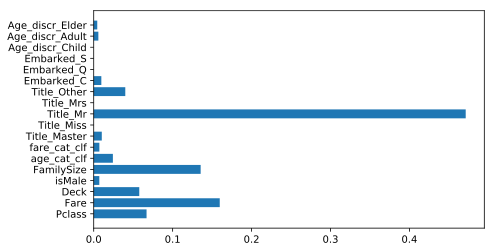

In [78]:
clf = DecisionTreeClassifier(max_depth=7)
clf.fit(X_train_imputed_scaled, y_train)

plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
plt.yticks(np.arange(len(X_train_imputed_scaled.columns)),X_train_imputed_scaled.columns)

##### - Эксперемент 3

In [79]:
depths = np.arange(1,10)
#features_num = np.arange(5,15)
grid = {'max_depth': depths}#, 'max_features': features_num}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='accuracy', cv=5)

In [80]:
%%time
gridsearch.fit(X_train_imputed_scaled, y_train)

CPU times: user 159 ms, sys: 3.2 ms, total: 163 ms
Wall time: 161 ms


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [81]:
sorted(gridsearch.grid_scores_, key = lambda x: -x.mean_validation_score)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.82267, std: 0.02240, params: {'max_depth': 4},
 mean: 0.81706, std: 0.02924, params: {'max_depth': 3},
 mean: 0.80471, std: 0.01800, params: {'max_depth': 6},
 mean: 0.80359, std: 0.02607, params: {'max_depth': 5},
 mean: 0.78900, std: 0.02102, params: {'max_depth': 7},
 mean: 0.78788, std: 0.02614, params: {'max_depth': 8},
 mean: 0.78339, std: 0.02539, params: {'max_depth': 2},
 mean: 0.78339, std: 0.03207, params: {'max_depth': 9},
 mean: 0.77890, std: 0.01317, params: {'max_depth': 1}]

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


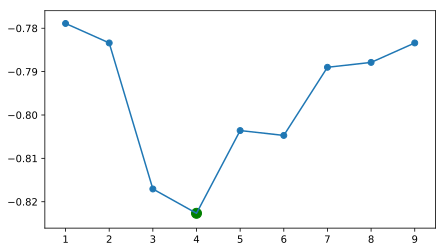

In [82]:
scores = [-x.mean_validation_score for x in gridsearch.grid_scores_]
plt.plot(depths, scores)
plt.scatter(depths, scores)
best_point = np.argmin(scores)
plt.scatter(depths[best_point], scores[best_point], c='g', s=100)

In [83]:
clf_final = DecisionTreeClassifier(max_depth=4)

In [84]:
clf_final.fit(X_train_imputed_scaled, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [85]:
from sklearn.metrics import accuracy_score

In [90]:
y_val_pred = clf_final.predict(X_train_imputed_scaled)

In [91]:
accuracy_score(y_train, y_val_pred)

0.8395061728395061

##### - Эксперемент 4

In [92]:
exp_tree_4 = DecisionTreeClassifier(max_depth=7, max_features=0.5, random_state=11)

In [93]:
cross_val_score(exp_tree_4, X_train_imputed_scaled, y_train, cv=5)

array([0.82681564, 0.79888268, 0.80898876, 0.79775281, 0.84180791])

In [94]:
np.mean(cross_val_score(exp_tree_4, X_train_imputed_scaled, y_train, cv=10))*100

81.6026273975712

In [95]:
exp_tree_4.fit(X_train_imputed_scaled, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=11,
            splitter='best')

In [96]:
y_val_pred = exp_tree_4.predict(X_train_imputed_scaled)

In [97]:
accuracy_score(y_train, y_val_pred)

0.8866442199775533

#####  Делаем финальное предсказание (модель clf_final)

In [ ]:
predictions = clf_final.predict(X_test_imputed_scaled)

In [92]:
submussion = 'PassengerId,Survived\n'
submussion += "\n".join(["{},{}".format(pid, predictions) for pid, predictions in zip(test.PassengerId, predictions)])

In [100]:
with open('submission_3.csv', 'w') as file:
    file.write(submussion)

#####  Делаем финальное предсказание (модель clf)

In [ ]:
predictions_1 = clf.predict(X_test_imputed_scaled)

In [97]:
submussion = 'PassengerId,Survived\n'
submussion += "\n".join(["{},{}".format(pid, predictions_1) for pid, predictions_1 in zip(test.PassengerId, predictions_1)])

In [99]:
with open('submission_4.csv', 'w') as file:
    file.write(submussion)

#####  Делаем финальное предсказание (модель first_tree_2)

In [96]:
first_tree_2.fit(X_train_imputed_scaled, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=15,
            splitter='best')

In [97]:
y_val_pred_1 = first_tree_2.predict(X_train_imputed_scaled)

In [98]:
accuracy_score(y_train, y_val_pred_1)

0.8686868686868687

In [107]:
predictions_2 = first_tree_2.predict(X_test_imputed_scaled)

In [112]:
submussion_1 = 'PassengerId,Survived\n'
submussion_1 += "\n".join(["{},{}".format(pid, predictions_2) for pid, predictions_2 in zip(test.PassengerId, predictions_2)])

In [113]:
with open('submission_5.csv', 'w') as file:
    file.write(submussion_1)

#####  Делаем финальное предсказание (модель first_tree_6)

In [ ]:
predictions_3 = first_tree_6.predict(X_test_imputed_scaled)

In [132]:
submussion_2 = 'PassengerId,Survived\n'
submussion_2 += "\n".join(["{},{}".format(pid, predictions_3) for pid, predictions_3 in zip(test.PassengerId, predictions_3)])

In [134]:
with open('submission_6.csv', 'w') as file:
    file.write(submussion_2)

#####  Делаем финальное предсказание (модель exp_tree_4)

In [ ]:
predictions_4 = exp_tree_4.predict(X_test_imputed_scaled)

In [67]:
submussion5 = 'PassengerId,Survived\n'
submussion5 += "\n".join(["{},{}".format(pid, predictions_4) for pid, predictions_4 in zip(test.PassengerId, predictions_4)])

In [68]:
with open('submission_7.csv', 'w') as file:
    file.write(submussion5)

#####  Делаем финальное предсказание (модель exp_tree_4) II

In [109]:
predictions_66 = exp_tree_4.predict(X_test_imputed_scaled)

In [92]:
submussion66 = 'PassengerId,Survived\n'
submussion66 += "\n".join(["{},{}".format(pid, predictions_66) for pid, predictions_66 in zip(test.PassengerId, predictions_66)])

In [93]:
with open('submission_8.csv', 'w') as file:
    file.write(submussion66)

#####  Делаем финальное предсказание (модель first_tree_2) II

In [110]:
predictions_686 = first_tree_2.predict(X_test_imputed_scaled)

In [100]:
submussion9 = 'PassengerId,Survived\n'
submussion9 += "\n".join(["{},{}".format(pid, predictions_686) for pid, predictions_686 in zip(test.PassengerId, predictions_686)])

In [102]:
with open('submission_9.csv', 'w') as file:
    file.write(submussion9)

#####  Делаем финальное предсказание (модель clf_final) II

In [104]:
predictions_00 = clf_final.predict(X_test_imputed_scaled)

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [105]:
submussion00 = 'PassengerId,Survived\n'
submussion00 += "\n".join(["{},{}".format(pid, predictions_00) for pid, predictions_00 in zip(test.PassengerId, predictions_00)])

In [106]:
with open('submission_10.csv', 'w') as file:
    file.write(submussion00)

### Выводы lvl 1

Лучший результат на Kaggle я получил используя модель first_tree_2

### Визуализируем само дерево

In [98]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names))

In [99]:
first_tree_2.fit(X_train_imputed_scaled, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=15,
            splitter='best')

In [100]:
get_tree_dot_view(first_tree_2, list(X_train_imputed_scaled.columns))

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="Title_Mr <= -0.163\ngini = 0.473\nsamples = 891\nvalue = [549, 342]", fillcolor="#e5813960"] ;
1 [label="FamilySize <= 1.609\ngini = 0.422\nsamples = 374\nvalue = [113, 261]", fillcolor="#399de591"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Pclass <= 0.229\ngini = 0.346\nsamples = 323\nvalue = [72, 251]", fillcolor="#399de5b6"] ;
1 -> 2 ;
3 [label="Title_Other <= 3.141\ngini = 0.215\nsamples = 196\nvalue = [24, 172]", fillcolor="#399de5db"] ;
2 -> 3 ;
4 [label="Fare <= -0.067\ngini = 0.108\nsamples = 175\nvalue = [10, 165]", fillcolor="#399de5f0"] ;
3 -> 4 ;
5 [label="Fare <= -0.08\ngini = 0.195\nsamples = 73\nvalue = [8, 65]", fillcolor="#399de5e0"] ;
4 -> 5 ;
6 [label="Age_discr_Child <= 1.692\ngini = 0.176\nsamples = 72\nvalue = [7, 65]", fillcolor="#399de5e4"] ;
5 -> 6 ;
7 [label="gini = 0.195\nsamples = 64\nvalue = [7, 57]", fillcolor="#399de5e0"] ;
6 -> 7 ;
8 [label="gini = 